In [1]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation, SegformerConfig, AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")
backbone = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")

/home/wg25r/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized: ['segformer.encoder.test.bias', 'segformer.encoder.test.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
import torch
backbone.decode_head.classifier = torch.nn.Identity()

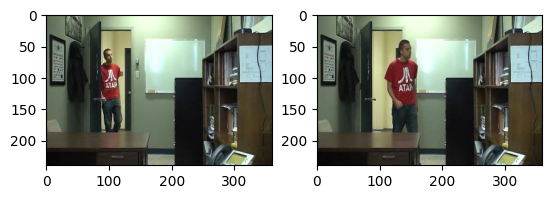

In [3]:
import os
import pylab
frames = os.listdir("/mnt/fastdata/dataset/baseline/office/input")
frames.sort()
pylab.subplot(1, 2, 1)
pylab.imshow(pylab.imread("/mnt/fastdata/dataset/baseline/office/input/"+frames[600]))
pylab.subplot(1, 2, 2)
pylab.imshow(pylab.imread("/mnt/fastdata/dataset/baseline/office/input/"+frames[640]))

In [4]:
from PIL import Image
backbone = backbone.eval()
image1 = image_processor(Image.open("/mnt/fastdata/dataset/baseline/office/input/"+frames[600]), return_tensors="pt")
image2 = image_processor(Image.open("/mnt/fastdata/dataset/baseline/office/input/"+frames[640]), return_tensors="pt")
image1_feature = backbone(**image1).logits 
image2_feature = backbone(**image2).logits

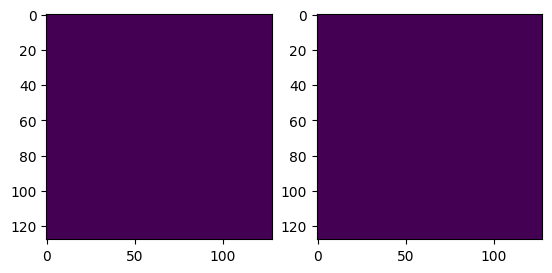

In [5]:
pylab.subplot(1, 2, 1) 
pylab.imshow((image1_feature.argmax(1)[0].detach())==12)
pylab.subplot(1, 2, 2)
pylab.imshow(image2_feature.argmax(1)[0].detach()==12)


In [6]:
image1_feature = image1_feature.permute(0, 2, 3, 1).flatten(1, 2)[0]
image2_feature = image2_feature.permute(0, 2, 3, 1).flatten(1, 2)[0]

In [7]:
grid = torch.stack(torch.meshgrid(torch.arange(128), torch.arange(128)), dim=-1).float()

/home/wg25r/.local/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
# import numpy as np
# import cv2
# matching = (image1_feature @ image2_feature.T)/np.sqrt(768)
# flow = (matching.softmax(0)[:,:,None] * grid.flatten(0,1) - grid.flatten(0,1)).detach()/128
# flow = torch.stack([flow[:,:,0], torch.ones(size=flow[:,:,1].shape), flow[:,:,1]], dim=-1)
# pylab.imshow(cv2.cvtColor((flow.numpy() * 255).astype(np.uint8), cv2.COLOR_HSV2BGR)) 

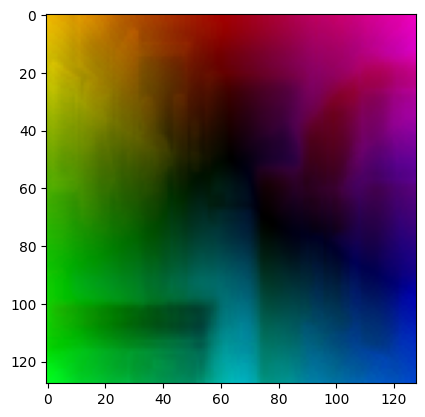

In [ ]:
import numpy as np
import cv2
matching = (image1_feature @ image2_feature.T)/np.sqrt(768) 
flow = (((matching.softmax(-1) @ grid.flatten(0, 1)) - grid.flatten(0, 1)).reshape(128,128,2).detach()/128)
# flow = torch.stack([flow[:,:,0], torch.ones(size=flow[:,:,1].shape), flow[:,:,1]], dim=-1)
# pylab.imshow(cv2.cvtColor((flow.numpy() * 200).astype(np.uint8), cv2.COLOR_HSV2BGR)) 
# pylab.imshow(flow.abs().max(-1).values.detach().numpy())
# pylab.imshow(matching.detach())  

hsv = np.zeros((128,128,3), dtype=np.uint8)
hsv[..., 1] = 255

mag, ang = cv2.cartToPolar(flow[..., 0].detach().numpy(), flow[..., 1].detach().numpy())
hsv[..., 0] = ang*180/np.pi/2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB) #huxikunduzikun cannot do this because background has same embeding values
pylab.imshow(rgb) 

In [10]:
(matching.softmax(-1) @ grid_.flatten(0, 1)).shape, grid_.flatten(0, 1).shape

NameError: name 'grid_' is not defined

In [ ]:
grid_.flatten(0, 1).shape

torch.Size([16384, 3])